# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data 分好数据
  mask = range(num_training, num_training + num_validation) # （49000,49000 + 1000）
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training) # （0， 49000）
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test) # （0， 1000）
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False) #在（0,49000）选num_dev个数作为array。
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows 把三维照片变成二维
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image 许多sample合聚成一个sample，求平均值。 归一化
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image

#     归一化是为了加快训练网络的收敛性，可以不进行归一化处理；
#     归一化的具体作用是归纳统一样本的统计分布性。归一化在0-1之间是统计的概率分布，归一化在-1--+1之间是统计的坐标分布。
#     归一化有同一、统一和合一的意思。无论是为了建模还是为了计算，首先基本度量单位要同一，
#     神经网络是以样本在事件中的统计分别几率来进行训练（概率计算）和预测的，归一化是同一在0-1之间的统计概率分布；
#     当所有样本的输入信号都为正值时，与第一隐含层神经元相连的权值只能同时增加或减小，从而导致学习速度很慢。
#     为了避免出现这种情况，加快网络学习速度，可以对输入信号进行归一化，使得所有样本的输入信号其均值接近于0或与其均方差相比很小。
#     防止饱和
  
  # add bias dimension and transform into columns 把bias加进去，后面训练只对w训练就可以了
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001 # 留个疑问，为什么这里要乘一个这么少的数？
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.316339
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *答案是说，因为有num_class = 10， 所以根据概率分布，每个class有0.1的机会被选中，我感觉有点牵扯。*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.502360 analytic: 0.502360, relative error: 9.683988e-09
numerical: 2.002715 analytic: 2.002715, relative error: 9.536672e-09
numerical: 1.406114 analytic: 1.406114, relative error: 1.298248e-08
numerical: 1.788182 analytic: 1.788182, relative error: 2.044912e-08
numerical: 2.507141 analytic: 2.507141, relative error: 3.403652e-08
numerical: 1.969018 analytic: 1.969018, relative error: 5.088942e-09
numerical: 3.944509 analytic: 3.944509, relative error: 6.101408e-10
numerical: -1.491830 analytic: -1.491830, relative error: 1.885570e-08
numerical: -3.278517 analytic: -3.278517, relative error: 1.513192e-08
numerical: 1.009309 analytic: 1.009309, relative error: 2.982220e-08
numerical: -0.075738 analytic: -0.075738, relative error: 2.822156e-07
numerical: 0.109802 analytic: 0.109802, relative error: 1.867052e-07
numerical: -2.468427 analytic: -2.468427, relative error: 1.973370e-09
numerical: 0.715264 analytic: 0.715264, relative error: 3.955387e-08
numerical: -2.322956 analy

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.316339e+00 computed in 0.143695s
vectorized loss: 2.316339e+00 computed in 0.531090s
Loss difference: 0.000000
Gradient difference: 0.000000


In [9]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e5]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in np.linspace(learning_rates[0],learning_rates[1],5):
    for reg in np.linspace(regularization_strengths[0],regularization_strengths[1],5):
        softmax = Softmax()
        loss_list = softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1000,
            batch_size=200, verbose=False)
        train_pre = softmax.predict(X_train)
        val_pre = softmax.predict(X_val)
        train_acc = np.mean(y_train == train_pre)
        val_acc = np.mean(y_val == val_pre)
        results[(lr,reg)] = (train_acc,val_acc)
        
        if best_val < val_acc:
            best_val = val_acc
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.332816 val accuracy: 0.343000
lr 1.000000e-07 reg 6.250000e+04 train accuracy: 0.316367 val accuracy: 0.329000
lr 1.000000e-07 reg 7.500000e+04 train accuracy: 0.319061 val accuracy: 0.330000
lr 1.000000e-07 reg 8.750000e+04 train accuracy: 0.313551 val accuracy: 0.323000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.305347 val accuracy: 0.328000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.331612 val accuracy: 0.353000
lr 2.000000e-07 reg 6.250000e+04 train accuracy: 0.326469 val accuracy: 0.338000
lr 2.000000e-07 reg 7.500000e+04 train accuracy: 0.312898 val accuracy: 0.323000
lr 2.000000e-07 reg 8.750000e+04 train accuracy: 0.305429 val accuracy: 0.328000
lr 2.000000e-07 reg 1.000000e+05 train accuracy: 0.305388 val accuracy: 0.319000
lr 3.000000e-07 reg 5.000000e+04 train accuracy: 0.332673 val accuracy: 0.341000
lr 3.000000e-07 reg 6.250000e+04 train accuracy: 0.313510 val accuracy: 0.327000
lr 3.000000e-07 reg 7.500000

In [10]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.350000


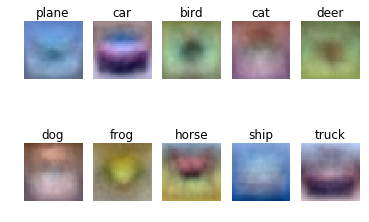

In [11]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])